## Setup

In [11]:
import sys
sys.path.append("/home/ubuntu/mlab/days/w3d3/rl_env/lib/python3.9/site-packages")


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import gym

In [16]:
env_name = "CartPole-v1"
record = True
video_name = "test_0"

env = gym.make(env_name)
if record:
    video_recorder = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,         
        path=f"videos/{video_name}.mp4"
    )
state = env.reset()
done = False
total_reward = 0

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

states = 0
while not done:
    states += 1
    if record:
        video_recorder.capture_frame()
    else:  
        show_state(env)
    state, reward, done, _ = env.step(env.action_space.sample()) # Take a random action
    total_reward += reward

print(f"total reward: {total_reward}")
if record:
    video_recorder.close()



total reward: 13.0


In [10]:
import gym
from gym import wrappers
env_name = "CartPole-v1"
record = False
video_name = "test2"

env_to_wrap = gym.make('CartPole-v0')
env = wrappers.Monitor(env_to_wrap, './gooder_test', force = True)
state = env.reset()
done = False
total_reward = 0

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

states = 0
while not done:
    states += 1
    #show_state(env)
    state, reward, done, _ = env.step(env.action_space.sample())
    total_reward += reward

print(f"total reward: {total_reward}")


env.close()
env_to_wrap.close()

total reward: 40.0


## DQN

In [3]:
from collections import namedtuple
from copy import deepcopy
import einops
import gym
import matplotlib.pyplot as plt
import numpy as np
import pdb
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

%matplotlib inline

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
Exp = namedtuple("Exp", ["state_0", "action", "reward", "state_1", "done"])

class ReplayBuffer():
    
    def __init__(self, max_size=10_000):
        self.max_size = max_size
        self.memory = []
        
    def add_exp(self, exp):
        self.memory.append(exp)
        if len(self.memory) >= self.max_size:
            self.memory.pop(0)

In [5]:
class LinearDQNet(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size, dueling=True, dueling_hidden_size=256):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.layer1 = nn.Linear(in_size, hidden_size).to(DEVICE)
        self.layer2 = nn.Linear(hidden_size, hidden_size).to(DEVICE)
        if dueling:
            self.layer3 = DuelingLayers(hidden_size, dueling_hidden_size, out_size).to(DEVICE)
        else:
            self.layer3 = nn.Linear(hidden_size, out_size).to(DEVICE)
        self.relu = nn.ReLU().to(DEVICE)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
class DuelingLayers(nn.Module):
    
    def __init__(self, in_size, dueling_hidden_size, num_actions):
        super().__init__()
        self.val_stream = nn.Sequential(
            nn.Linear(in_size, dueling_hidden_size),
            nn.ReLU(),
            nn.Linear(dueling_hidden_size, 1)
        )
        self.adv_stream = nn.Sequential(
            nn.Linear(in_size, dueling_hidden_size),
            nn.ReLU(),
            nn.Linear(dueling_hidden_size, num_actions),
        )
        
    def forward(self, x):
        val = self.val_stream(x)
        adv = self.adv_stream(x)
        adv -= adv.mean()
        return val + adv

In [7]:
def preprocess_atari(state):
    state = torch.tensor(state).to(torch.float32).to(DEVICE)
    if len(state.shape) == 3:
        state /= 255.0
        state = einops.rearrange(state, "h w c -> c w h")
    return state.unsqueeze(0) 

In [8]:
def evaluate(model, env, epsilon=0.0, record=True, video_name=None):
    if record:
        video_recorder = gym.wrappers.monitoring.video_recorder.VideoRecorder(
            env, path=f"videos/{video_name}.mp4"
        )
    state = preprocess_atari(env.reset())
    done = False
    ep_reward = 0.0

    while not done:
        if record:
            video_recorder.capture_frame()
        if np.random.random() < epsilon:
            action = np.random.randint(env.action_space.n)
        else:
            q_actions = model(state)
            action = q_actions.argmax().item()
        state_next, reward, done, _ = env.step(action)
        state = preprocess_atari(state_next)
        ep_reward += reward
    
    if record:
        video_recorder.close()
        
    return ep_reward

In [11]:
# TODO make gin.configurable?
def train(
    model, env, max_steps=200_000, epsilon_start=0.5, epsilon_end=0.05, epsilon_decay_steps=100_000, 
    epsilon_eval=0.0, lr=1e-3, gamma=0.98, batch_size=128, replay_size=10_000, sample_every=16,
    multistep=1, update_target_every=5_000, eval_every=10_000, eval_episodes=5, 
    loss_fn=nn.MSELoss()
):
    pbar = tqdm(total=max_steps)
    target_model = deepcopy(model)
    replay = ReplayBuffer(max_size=10_000)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ep_rewards = []
    ep = 0
    total_steps = 0
    eval_at = 0
    update_target_at = 0
    
    while total_steps < max_steps:
        if total_steps >= eval_at:
            rewards = [evaluate(
                model, env, epsilon=epsilon_eval, record=ep==eval_episodes-1, video_name=str(eval_at)
            ) for ep in range(eval_episodes)]
            print(f"step {eval_at}: mean reward = {sum(rewards) / len(rewards):.2f}")
            eval_at += eval_every
        if total_steps > update_target_at:
            target_model = deepcopy(model)
            update_target_at += sample_every * update_target_every
        state = env.reset()
        done = False
        ep_reward = 0.0
        epsilon_decay_frac = min(total_steps, epsilon_decay_steps) / epsilon_decay_steps
        epsilon = epsilon_start + epsilon_decay_frac * (epsilon_end - epsilon_start)
        while not done:
            if np.random.random() < epsilon:
                action = np.random.randint(env.action_space.n)
            else:
                q_actions = model(preprocess_atari(state))
                action = q_actions.argmax().item()
            state_next, reward, done, _ = env.step(action)
            replay.add_exp(Exp(state, action, reward, state_next, done))
            ep_reward += reward
            state = state_next
            total_steps += 1
            pbar.update(1)
            if total_steps % sample_every == 0 and len(replay.memory) >= batch_size:
                optimizer.zero_grad()
                state_0s = []
                actions = []
                rewards = []
                state_1s = []
                dones = []
                idxs = np.random.choice(range(len(replay.memory) - multistep), batch_size)
                for idx in idxs:
                    exp = replay.memory[idx]
                    state_0s.append(exp.state_0)
                    actions.append(exp.action)
                    step_reward = 0.0
                    for i_step in range(multistep):
                        i_exp = replay.memory[idx + i_step]
                        step_reward += i_exp.reward
                        i_done = i_exp.done
                        if i_done:
                            break
                    rewards.append(step_reward)
                    dones.append(i_done)
                    state_1s.append(replay.memory[idx + multistep - 1].state_1)

                state_0s = torch.cat([preprocess_atari(state_0) for state_0 in state_0s]).to(DEVICE)
                actions = torch.tensor(actions, requires_grad=False, device=DEVICE)
                rewards = torch.tensor(rewards, requires_grad=False, device=DEVICE, dtype=torch.float32)
                dones = torch.tensor(dones, requires_grad=False, device=DEVICE, dtype=bool)
                state_1s = torch.cat([preprocess_atari(state_1) for state_1 in state_1s]).to(DEVICE)
                target_actions = model(state_1s).detach().argmax(dim=1)
                q_target = gamma * target_model(state_1s).detach().gather(1, target_actions.unsqueeze(-1)).squeeze()
                q_target[dones] = 0.0
                q_actual = model(state_0s).gather(1, actions.unsqueeze(-1)).squeeze()
                loss = loss_fn(rewards + q_target, q_actual)
                loss.backward()
                optimizer.step()
            if total_steps >= max_steps:
                break
            
        ep_rewards.append(ep_reward)
        ep += 1

    pbar.close()    
    if len(ep_rewards) > 5000:
        rewards = [ep_rewards[i*100:(i+1)*100] for i in range(len(ep_rewards)//100)]
        plt.plot([sum(r) / len(r) for r in rewards])
    else:
        plt.plot(ep_rewards)

## CartPole-v1

  0%|          | 0/100000 [00:00<?, ?it/s]

step 0: mean reward = 9.20
step 10000: mean reward = 168.80
step 20000: mean reward = 256.20
step 30000: mean reward = 336.00
step 40000: mean reward = 249.80
step 50000: mean reward = 341.20
step 60000: mean reward = 298.40
step 70000: mean reward = 278.00
step 80000: mean reward = 297.40
step 90000: mean reward = 288.80


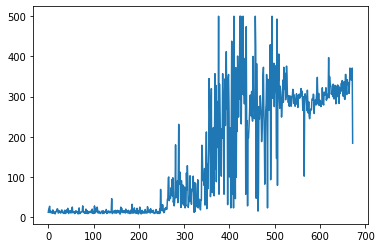

In [12]:
def train_cartpole_with_epsilon(eps):
    env = gym.make("CartPole-v1")
    model = LinearDQNet(
        in_size=len(env.reset()), hidden_size=64, out_size=env.action_space.n, num_actions=env.action_space.n
    )
    train(model=model, env=env, max_steps=20_000, epsilon_start=eps, epsilon_end=eps)

# train_cartpole_with_epsilon(0.05)

# train_cartpole_with_epsilon(0.9)

# train_cartpole_with_epsilon(0.5)

# train_cartpole_with_epsilon(0.005)

# train_cartpole_with_epsilon(0.001)

env = gym.make("CartPole-v1")
model = LinearDQNet(
    in_size=len(env.reset()), hidden_size=64, out_size=env.action_space.n, dueling_hidden_size=32
)
train(
    model=model, env=env, max_steps=100_000, epsilon_start=0.5, epsilon_end=0.05, 
    epsilon_decay_steps=100_000, update_target_every=10
)

## Acrobot-v1

In [ ]:
env = gym.make("Acrobot-v1")
model = LinearDQNet(
    in_size=len(env.reset()), hidden_size=64, out_size=env.action_space.n, dueling_hidden_size=32
)
train(
    model=model, 
    env=env, 
    max_steps=100_000, 
    epsilon_start=1.0, 
    epsilon_end=0.1, 
    epsilon_decay_steps=10_000,
    lr=1e-4,
    gamma=0.99,
    batch_size=128,
    sample_every=4,
    eval_every=10_000,
    render_every=50_000,
    update_target_every=10,
)

## BreakoutNoFrameskip-v0

In [ ]:
class ConvDQNet(nn.Module):
    
    def __init__(self, in_channels, out_size, dueling=True, dueling_hidden_size=256):
        super().__init__()
        if dueling:
            last_layer = DuelingLayers(3136, dueling_hidden_size, out_size).to(DEVICE)
        else:
            last_layer = nn.Linear(3136, out_size)
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            last_layer,
        ).to(DEVICE)
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
from collections import deque

import gym
import numpy as np
from gym import spaces
import cv2

cv2.ocl.setUseOpenCL(False)

from stable_baselines3.common.type_aliases import GymObs, GymStepReturn


class NoopResetEnv(gym.Wrapper):
    """
    Sample initial states by taking random number of no-ops on reset.
    No-op is assumed to be action 0.

    :param env: the environment to wrap
    :param noop_max: the maximum value of no-ops to run
    """
    def __init__(self, env: gym.Env, noop_max: int = 30):
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == "NOOP"

    def reset(self, **kwargs) -> np.ndarray:
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = np.zeros(0)
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs


class FireResetEnv(gym.Wrapper):
    """
    Take action on reset for environments that are fixed until firing.

    :param env: the environment to wrap
    """
    def __init__(self, env: gym.Env):
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == "FIRE"
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs) -> np.ndarray:
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs


class EpisodicLifeEnv(gym.Wrapper):
    """
    Make end-of-life == end-of-episode, but only reset on true game over.
    Done by DeepMind for the DQN and co. since it helps value estimation.

    :param env: the environment to wrap
    """
    def __init__(self, env: gym.Env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action: int) -> GymStepReturn:
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs) -> np.ndarray:
        """
        Calls the Gym environment reset, only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.

        :param kwargs: Extra keywords passed to env.reset() call
        :return: the first observation of the environment
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    """
    Return only every ``skip``-th frame (frameskipping)

    :param env: the environment
    :param skip: number of ``skip``-th frame
    """
    def __init__(self, env: gym.Env, skip: int = 4):
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2, ) + env.observation_space.shape,
                                    dtype=env.observation_space.dtype)
        self._skip = skip

    def step(self, action: int) -> GymStepReturn:
        """
        Step the environment with the given action
        Repeat action, sum reward, and max over last observations.

        :param action: the action
        :return: observation, reward, done, information
        """
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: 
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs) -> GymObs:
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    """
    Clips the reward to {+1, 0, -1} by its sign.

    :param env: the environment
    """
    def __init__(self, env: gym.Env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward: float) -> float:
        """
        Bin reward to {+1, 0, -1} by its sign.

        :param reward:
        :return:
        """
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    """
    Convert to grayscale and warp frames to 84x84 (default)
    as done in the Nature paper and later work.

    :param env: the environment
    :param width:
    :param height:
    """
    def __init__(self, env: gym.Env, width: int = 84, height: int = 84):
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.observation_space = spaces.Box(low=0,
                                            high=255,
                                            shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height),
                           interpolation=cv2.INTER_AREA)
        return frame[:, :, None]


class FrameStack(gym.Wrapper):
    def __init__(self, env, k, channel_order="hwc"):
        """Stack k last frames.
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        self.stack_axis = {"hwc": 2, "chw": 0}[channel_order]
        orig_obs_space = env.observation_space
        low = np.repeat(orig_obs_space.low, k, axis=self.stack_axis)
        high = np.repeat(orig_obs_space.high, k, axis=self.stack_axis)
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=orig_obs_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return np.concatenate(list(self.frames), axis=self.stack_axis)


class AtariWrapper(gym.Wrapper):
    """
    Atari 2600 preprocessings

    Specifically:

    * NoopReset: obtain initial state by taking random number of no-ops on reset.
    * Frame skipping: 4 by default
    * Max-pooling: most recent two observations
    * Termination signal when a life is lost.
    * Resize to a square image: 84x84 by default
    * Grayscale observation
    * Clip reward to {-1, 0, 1}

    :param env: gym environment
    :param noop_max: max number of no-ops
    :param frame_skip: the frequency at which the agent experiences the game.
    :param screen_size: resize Atari frame
    :param terminal_on_life_loss: if True, then step() returns done=True whenever a life is lost.
    :param clip_reward: If True (default), the reward is clip to {-1, 0, 1} depending on its sign.
    """
    def __init__(
        self,
        env: gym.Env,
        noop_max: int = 30,
        frame_skip: int = 4,
        frame_stack: int = 4,
        screen_size: int = 84,
        terminal_on_life_loss: bool = True,
        clip_reward: bool = True,
    ):
        env = NoopResetEnv(env, noop_max=noop_max)
        env = MaxAndSkipEnv(env, skip=frame_skip)
        if terminal_on_life_loss:
            env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = WarpFrame(env, width=screen_size, height=screen_size)
        if clip_reward:
            env = ClipRewardEnv(env)
        env = FrameStack(env, frame_stack)

        super(AtariWrapper, self).__init__(env)

In [ ]:
# from days.atari_wrappers import AtariWrapper
# from stable_baselines3.common.atari_wrappers import AtariWrapper

env = gym.make("BreakoutNoFrameskip-v0")
env = AtariWrapper(env)
model = ConvDQNet(in_channels=env.reset().shape[2], out_size=env.action_space.n)
train(
    model=model, 
    env=env, 
    max_steps=2_000_000,
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay_steps=1_000_000,
    epsilon_eval=0.05,
    lr=3e-5,
    gamma=0.99,
    batch_size=32,
    replay_size=100_000,
    sample_every=4,
    eval_every=50_000,
    render_every=50_000,
    update_target_every=2_000,
    multistep=1,
)

In [ ]:
env = gym.make("BreakoutNoFrameskip-v0")
env = AtariWrapper(env)
model = ConvDQNet(in_channels=env.reset().shape[2], out_size=env.action_space.n)
train(
    model=model, 
    env=env, 
    max_steps=2_000_000,
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay_steps=1_000_000,
    epsilon_eval=0.05,
    lr=3e-5,
    gamma=0.99,
    batch_size=32,
    replay_size=100_000,
    sample_every=4,
    eval_every=50_000,
    render_every=50_000,
    update_target_every=2_000,
    multistep=3,
)

## Policy Gradient

In [ ]:
from collections import namedtuple
from copy import deepcopy
import einops
import gym
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

%matplotlib inline

# DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu:0"

In [ ]:
class PGNet(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.layers(x)

In [ ]:
def action_probs(model, states):
    return torch.distributions.categorical.Categorical(model(states))

def batch_loss(model, states, actions, rewards):
    logprob = action_probs(model, states).log_prob(actions)
    return (-1.0 * logprob * rewards).mean()

In [ ]:
def evaluate(env_name, model):
    env = gym.make(env_name)
    state = torch.tensor(env.reset(), dtype=torch.float32)
    done = False
    ep_reward = 0.0

    while not done:
        action = action_probs(model, state).sample().item()
        state_next, reward, done, _ = env.step(action)
        state = torch.tensor(state_next, dtype=torch.float32)
        ep_reward += reward
        
    return ep_reward

In [ ]:
def train(
    env_name, num_epochs, batch_size, lr, hidden_size=64, eval_episodes=10,
    rewards_to_go=False, gen_adv_est=False
):
    env = gym.make(env_name)
    max_steps = num_epochs * batch_size
    steps = 0
    in_size = env.reset().shape[0]
    out_size = env.action_space.n
    model = PGNet(in_size, hidden_size, out_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    final_ep_rewards = []
        
    for epoch in range(num_epochs):
        batch_states = []
        batch_actions = []
        batch_rewards = []
        done = False
        ep_states = []
        ep_actions = []
        ep_rewards = []
        state = torch.tensor(env.reset(), dtype=torch.float32)
        
        for step in range(batch_size):
            action = action_probs(model, state).sample().item()
            state_next, reward, done, _ = env.step(action)
            ep_states.append(state)
            ep_actions.append(action)
            ep_rewards.append(reward)
            if done:
                final_ep_rewards.append(sum(ep_rewards))
                if rewards_to_go:
                    ep_rewards = (np.cumsum(ep_rewards[::-1])[::-1] - ep_rewards).tolist()
                else:
                    ep_rewards = [sum(ep_rewards)] * len(ep_rewards)
                batch_states.extend(ep_states)
                batch_actions.extend(ep_actions)
                batch_rewards.extend(ep_rewards)
                ep_states = []
                ep_actions = []
                ep_rewards = []
                state = torch.tensor(env.reset(), dtype=torch.float32)
                done = False
            else:
                state = torch.tensor(state_next, dtype=torch.float32)
            
        optimizer.zero_grad()
        batch_states = torch.stack(batch_states)
        batch_actions = torch.tensor(batch_actions, dtype=torch.float32)
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32)
        L = batch_loss(model, batch_states, batch_actions, batch_rewards)
        L.backward()
        optimizer.step()
        
        eval_rewards = []
        for ep in range(eval_episodes):
            reward = evaluate(env_name, model)
            eval_rewards.append(reward)
        mean_reward = sum(eval_rewards) / eval_episodes
        print(f"epoch {epoch}: reward {mean_reward}")
        
    num_groups = 200
    eps_per_group = len(final_ep_rewards) // num_groups
    final_ep_rewards = [
        sum(final_ep_rewards[i*eps_per_group : (i+1)*eps_per_group]) / eps_per_group 
        for i in range(num_groups)
    ]
    plt.plot(final_ep_rewards)

In [ ]:
train(
    "CartPole-v1", 
    num_epochs=10,
    batch_size=5_000,
    lr=1e-2,
    hidden_size=64,
    eval_episodes=20,
)

In [ ]:
train(
    "CartPole-v1", 
    num_epochs=40,
    batch_size=5_000,
    lr=1e-2,
    hidden_size=64,
    eval_episodes=20,
)

In [ ]:
train(
    "CartPole-v1", 
    num_epochs=40,
    batch_size=5_000,
    lr=1e-2,
    hidden_size=64,
    eval_episodes=20,
    rewards_to_go=True,
)